In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## Synthetic Data (from Wu et al. (2007))

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples per region
n = 100

# Region 1: x1 in [0.1, 0.4], x2 in [0.1, 0.4], x3 in [0.6, 0.9]
x1_r1 = np.random.uniform(0.1, 0.4, n)
x2_r1 = np.random.uniform(0.1, 0.4, n)
x3_r1 = np.random.uniform(0.6, 0.9, n)

# Region 2: x1 in [0.1, 0.4], x2 in [0.6, 0.9], x3 in [0.6, 0.9]
x1_r2 = np.random.uniform(0.1, 0.4, n)
x2_r2 = np.random.uniform(0.6, 0.9, n)
x3_r2 = np.random.uniform(0.6, 0.9, n)

# Region 3: x1 in [0.6, 0.9], x2 in [0.1, 0.9], x3 in [0.1, 0.4]
x1_r3 = np.random.uniform(0.6, 0.9, n)
x2_r3 = np.random.uniform(0.1, 0.9, n)
x3_r3 = np.random.uniform(0.1, 0.4, n)

# Concatenate all
x1 = np.concatenate([x1_r1, x1_r2, x1_r3])
x2 = np.concatenate([x2_r1, x2_r2, x2_r3])
x3 = np.concatenate([x3_r1, x3_r2, x3_r3])

X = np.stack([x1, x2, x3], axis=1)

# Define output y based on the decision rules
def generate_y(x):
    x1 = x[0]
    x2 = x[1]
    if x1 <= 0.5:
        if x2 <= 0.5:
            return 1 + np.random.normal(0, np.sqrt(0.25))
        else:
            return 3 + np.random.normal(0, np.sqrt(0.25))
    else:
        return 5 + np.random.normal(0, np.sqrt(0.25))

y = np.array([generate_y(row) for row in X])

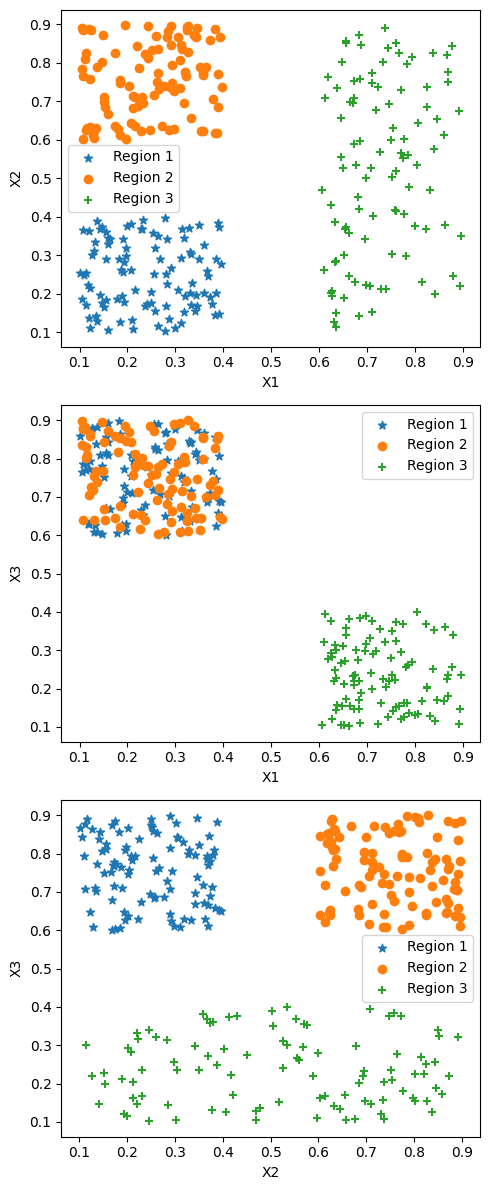

In [3]:
region = np.array([1]*n + [2]*n + [3]*n)
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(5, 12))

# First plot: X1 vs X2
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[0].scatter(x1[idx], x2[idx], marker=marker, label=f"Region {r}")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].legend()

# Second plot: X1 vs X3
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[1].scatter(x1[idx], x3[idx], marker=marker, label=f"Region {r}")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X3")
axs[1].legend()

# Third plot: X2 vs X3
for r, marker in zip([1, 2, 3], ['*', 'o', '+']):
    idx = region == r
    axs[2].scatter(x2[idx], x3[idx], marker=marker, label=f"Region {r}")
axs[2].set_xlabel("X2")
axs[2].set_ylabel("X3")
axs[2].legend()

plt.tight_layout()
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 4 Special Moves

In [5]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"birth": 0.5, "death": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}

In [6]:
n_trees_ini = 50
nskip = 20000
ndpost = 1000
theta_0_nskip_prop=0.5
def temperature_schedule(t):
    t_start = theta_0_nskip_prop * nskip
    if t <= t_start:
        return 1.0
    else:
        t_max = (theta_0_nskip_prop+0.3) * nskip
        temp_min = 0.1
        temp = 1.0 - (t - t_start) * (1.0 - temp_min) / (t_max - t_start)
        return max(temp, temp_min)
bart = ChangeNumTreeBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees_ini, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0_ini = n_trees_ini, theta_0_min = 10, theta_0_nskip_prop=theta_0_nskip_prop, theta_df = 100, 
                         #temperature = TemperatureSchedule(temperature_schedule),
                         temperature = 1.0,
                         tree_num_prior_type="poisson", special_move_interval=5)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 21000/21000 [01:44<00:00, 201.60it/s]


In [7]:
bart.trace[-1].n_trees

14

In [8]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00458115]), 'ntree_theta': 10.207135487409538}

In [9]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

14.57

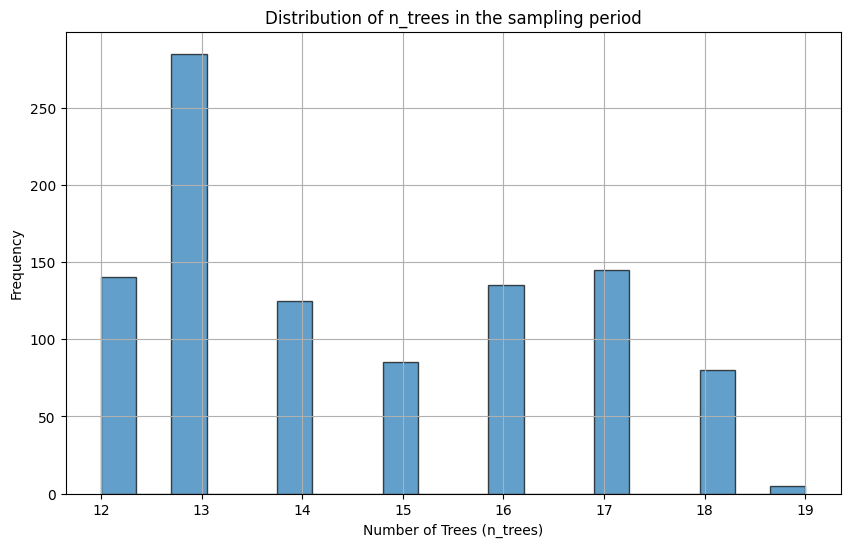

In [10]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

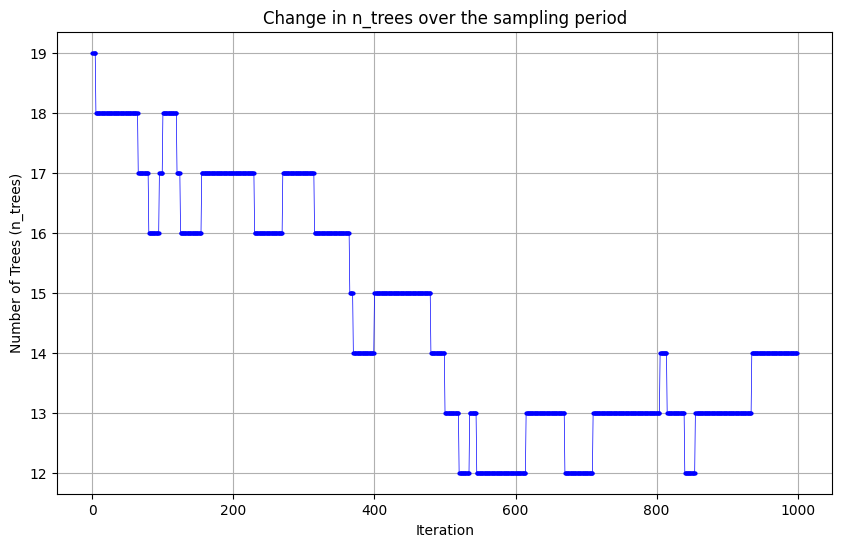

In [11]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [12]:
# Extract ntree_theta from global_params for each trace
ntree_theta_list = [trace.global_params['ntree_theta'] for trace in bart.trace]
np.mean(ntree_theta_list)

10.681429212795942

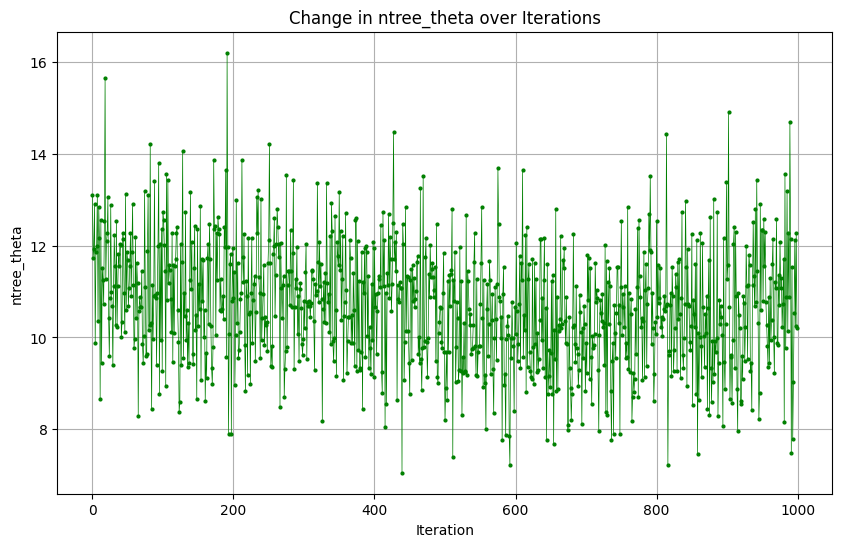

In [13]:
# Plot ntree_theta over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(ntree_theta_list)), ntree_theta_list, marker='o', markersize=2, linestyle='-', linewidth=0.5, color='g')
plt.title('Change in ntree_theta over Iterations')
plt.xlabel('Iteration')
plt.ylabel('ntree_theta')
plt.grid(True)
plt.show()

In [14]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=ndpost, nskip=2000)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-05-21 22:22:37,372:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-21 22:22:37,374:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration  100/3000 P_grow=0.50 P_prune=0.50 A_grow=0.43 A_prune=0.29 (burnin)
Iteration  200/3000 P_grow=0.57 P_prune=0.43 A_grow=0.25 A_prune=0.67 (burnin)
Iteration  300/3000 P_grow=0.50 P_prune=0.50 A_grow=0.29 A_prune=0.57 (burnin)
Iteration  400/3000 P_grow=0.36 P_prune=0.64 A_grow=0.00 A_prune=0.00 (burnin)
Iteration  500/3000 P_grow=0.43 P_prune=0.57 A_grow=0.17 A_prune=0.25 (burnin)
Iteration  600/3000 P_grow=0.71 P_prune=0.29 A_grow=0.70 A_prune=0.50 (burnin)
Iteration  700/3000 P_grow=0.57 P_prune=0.43 A_grow=0.25 A_prune=0.17 (burnin)
Iteration  800/3000 P_grow=0.57 P_prune=0.43 A_grow=0.25 A_prune=0.17 (burnin)
Iteration  900/3000 P_grow=0.50 P_prune=0.50 A_grow=0.29 A_prune=0.43 (burnin)
Iteration 1000/3000 P_grow=0.36 P_prune=0.64 A_grow=0.20 A_prune=0.33 (burnin)
Iteration 1100/3000 P_grow=0.43 P_prune=0.57 A_grow=0.00 A_prune=0.12 (burnin)
Iteration 1200/3000 P_grow=0.43 P_prune=0.57 A_grow=0.17 A_prune=0.50 (burnin)
Iteration 1300/3000 P_grow=0.64 P_prune=0.36 A_grow=

In [15]:
bart_default = DefaultBART(ndpost=ndpost, nskip=200, n_trees=ntree, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)

Iterations: 100%|██████████| 1200/1200 [00:02<00:00, 406.17it/s]


In [30]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz,
          "bart_default" : bart_default}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.3707666532619231,
 'rf': 0.43769294410801657,
 'lr': 0.6157610049142247,
 'btz': 0.34078940002308483,
 'bart_default': 0.3962086384648549}

In [33]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz,
          "bart_default" : bart_default}
results = {}
btpred_all = btz.predict(np.transpose(X_train))
btpred = np.mean(np.array(btpred_all), axis=0)
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_train, btpred)
    else:
        results[model_name] = mean_squared_error(y_train, model.predict(X_train))
results

{'bart': 0.15125559052986962,
 'rf': 0.040628345747202324,
 'lr': 0.6561262894516641,
 'btz': 0.17032823305338796,
 'bart_default': 0.15647759928748034}

In [17]:
if all([(bart.sampler.trace[-1].trees[i].evaluate() == bart.sampler.trace[-1].trees[i].evaluate(X_train)).all()
            for i in range(bart.sampler.trace[-1].n_trees)]):
    print("True")
else:
    print("False")

True


In [18]:
np.allclose(bart.sampler.trace[-1].evaluate(X_train), bart.sampler.trace[-1].evaluate(), atol=1e-10, rtol=1e-12)

True

In [19]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 1061; mh median: 0.02458065324946835


In [20]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 88; mh median: 2.607315608005919


In [21]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 446; mh median: 0.2660438434701549


In [22]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 776; mh median: 0.0358264558802193


In [23]:
bart.trace[-1].trees

[Tree(vars=[ 2 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.61105262        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.0265812  0.04170858        nan        nan        nan
         nan        nan], n_vals=[225  81 144  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.35692225        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan -0.08845097  0.00997556         nan         nan         nan
          nan         nan], n_vals=[225 130  95  -2  -2  -2  -2  -2]),
 Tree(vars=[-1 -2 -2 -2 -2 -2 -2 -2], thresholds=[nan nan nan nan nan nan nan nan], leaf_vals=[0.10936694        nan        nan        nan        nan        nan
         nan        nan], n_vals=[225  -2  -2  -2  -2  -2  -2  -2]),
 Tree(vars=[ 0 -1 -1 -2 -2 -2 -2 -2], thresholds=[0.28493378        nan        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan 0.01557898 0.02868877 

In [24]:
y_test

array([4.59153216, 5.09826058, 2.68113001, 1.30300498, 4.96712487,
       5.06648484, 3.53333734, 2.84541394, 1.52450461, 2.60085138,
       3.90059702, 1.5268209 , 4.95235223, 0.36021152, 2.99178855,
       5.09330456, 4.42081766, 5.37312678, 3.0832261 , 2.24212794,
       1.31090498, 2.55269635, 4.46495762, 4.23723741, 3.4691419 ,
       1.83273722, 3.78806034, 3.97913257, 3.59450827, 5.22000723,
       1.19956806, 3.10146151, 0.61084764, 1.15390088, 5.10957516,
       2.25721981, 0.29576935, 1.41696108, 0.68759071, 1.90622428,
       0.16951953, 1.31620387, 4.51651193, 1.24665895, 1.48627722,
       1.35015494, 4.72240024, 4.23840655, 2.76062569, 5.18860594,
       2.74119435, 2.97526815, 4.74897289, 0.71876661, 4.65900788,
       4.77690828, 0.36162571, 0.96491714, 3.29532742, 0.1449158 ,
       5.78276201, 2.31619103, 0.64782815, 2.73456561, 4.00510227,
       1.00921697, 0.81819389, 4.37423029, 0.51206337, 2.75528028,
       2.78275189, 4.14944906, 4.72053908, 3.55435179, 3.72669

In [25]:
bart.predict(X_test)

array([5.15804078, 5.08763111, 3.17124985, 1.16619533, 4.96573724,
       4.99983709, 3.42224295, 3.15499317, 0.58536768, 3.05831837,
       5.15568479, 1.0678508 , 4.98687832, 1.06520367, 3.18337018,
       4.55562795, 5.17336683, 5.11557745, 3.18706293, 3.18173773,
       1.00024882, 3.47860671, 5.09940389, 4.98978011, 3.3632281 ,
       0.67903225, 5.16407162, 5.13152431, 3.14794211, 5.1877639 ,
       1.06354677, 3.42044566, 1.05469664, 1.05333027, 5.3273297 ,
       3.18650493, 1.02466387, 0.9812235 , 1.0542745 , 0.49768316,
       1.0644294 , 1.13637892, 5.13394357, 1.0545705 , 1.07164549,
       1.04530645, 5.18259888, 5.19763615, 3.17155585, 5.32637956,
       3.20272054, 3.15415081, 5.11219063, 1.15557529, 5.11335488,
       5.04209714, 1.02733509, 1.12708537, 3.13307206, 1.17053373,
       4.96855856, 1.02249139, 1.03106307, 2.89107488, 3.17147541,
       1.0628702 , 1.07552123, 5.02967174, 1.04624011, 3.17390475,
       3.32711286, 3.1822342 , 5.00073062, 3.28938818, 3.13351

In [26]:
# Define output y based on the decision rules
def generate_ymean(x):
    x1 = x[0]
    x2 = x[1]
    if x1 <= 0.5:
        if x2 <= 0.5:
            return 1
        else:
            return 3
    else:
        return 5

y_test_mean = np.array([generate_ymean(row) for row in X_test])

In [27]:
y_test_mean

array([5, 5, 3, 1, 5, 5, 3, 3, 1, 3, 5, 1, 5, 1, 3, 5, 5, 5, 3, 3, 1, 3,
       5, 5, 3, 1, 5, 5, 3, 5, 1, 3, 1, 1, 5, 3, 1, 1, 1, 1, 1, 1, 5, 1,
       1, 1, 5, 5, 3, 5, 3, 3, 5, 1, 5, 5, 1, 1, 3, 1, 5, 1, 1, 3, 3, 1,
       1, 5, 1, 3, 3, 3, 5, 3, 3])

In [28]:
mean_squared_error(y_test, y_test_mean)

0.29066967121653925

In [29]:
mean_squared_error(bart.predict(X_test), y_test_mean)

0.036959642214561335